# Basic Usage Tutorial

Muhunden Jayakrishnan (last updated: *25/02/2025*)

Testing DL-models to predict developmental age from scRNA-seq data

## Configuring

Load necessary modules

In [1]:
# Change this to where you would like to save all your results
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing \
    import Normalization
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from scipy.io import mmread
import numpy as np
from scipy.sparse import vstack
from random import sample
from math import floor
from keras import backend as BK
from scipy.sparse import csr_matrix
import gc
from types import SimpleNamespace as PARS
import os


os.chdir("/work/project/becbec_005/singleCell/Seurat/250220_Calderon/")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

'/work/project/becbec_005/singleCell/Seurat/250220_Calderon'

## Helper functions
Helper functions to load, fit, predict and save data

a) open_data -> Opens our tsv containing labels (y_train) and RNA data values (x_train) and stack them (sparsely) for folds other than k. k'th fold will be used as the validation fold. The open_all version is used for fitting the final model to all data.


In [2]:
def open_data(k):
    fs = [i for i in range(10) if i != k]
    y_train = np.delete(np.concatenate([np.genfromtxt('k_folds_data/' + str(i+1) + \
        '_fold_rna_centers.tsv') for i in fs], axis=0), [1,2,3], 1)
    x_train = vstack([mmread('k_folds_data/' + str(i+1) + \
        '_fold_rna.mtx') for i in fs]).todense()
    
    # shuffle the training data
    p = np.arange(x_train.shape[0])
    np.random.shuffle(p)
    x_train, y_train = x_train[p,], y_train[p]
    del(p)
    gc.collect()
    
    y_validation = np.delete(np.genfromtxt('k_folds_data/' + str(k+1) + \
        '_fold_rna_centers.tsv'), [1,2, 3], 1)
    x_validation = mmread('k_folds_data/' + str(k+1) + \
        '_fold_rna.mtx').todense()
    return(y_train,x_train,y_validation,x_validation)


def open_all_data():
    fs = [i for i in range(10)]
    y_train = np.delete(np.concatenate([np.genfromtxt('k_folds_data/' + str(i+1) + \
        '_fold_rna_centers.tsv') for i in fs], axis=0), [1,2, 3], 1)
    x_train = vstack([mmread('k_folds_data/' + str(i+1) + \
        '_fold_rna.mtx') for i in fs]).todense()
    
    p = np.arange(x_train.shape[0])
    np.random.shuffle(p)
    x_train, y_train = x_train[p,], y_train[p]
    del(p)
    gc.collect()
    return(y_train,x_train)

b) make_model -> Standard model used in Calderon et al., 2022. Feedforward fully connected NN with 4 hidden layers; first normalization layer centers+scales all gene expression values. Variable output layer (activation functions defined later)

In [3]:
def make_model(run_id, x, normalize=False, out_fn=None, l1=0, l2=0):
    model = tf.keras.Sequential()
    if (normalize):
        normalizer = Normalization(axis=-1)
        normalizer.adapt(np.array(x))
        model.add(normalizer)
    
    model.add(layers.Dense(units=5, input_shape=(x.shape[1],), name='layer1',
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(layers.Dense(units=100, name='layer2', activation='relu'))
    model.add(layers.Dense(units=50, name='layer3', activation='relu'))
    model.add(layers.Dense(units=20, name='layer4', activation='relu'))
    model.add(layers.Dense(units=1, name='layer5',
        activation=out_fn))
    return(model)

Custom activation functions for output layer are as below. Outputs are restricted between upper and lower bounds of collection windows. tanh has steeper gradients; better for taking larger learning steps etc. 

In [3]:
# Add this as the activation of the final layer
# 'https://stackoverflow.com/questions/49911206/how-to-' +
#     '\restrict-output-of-a-neural-net-to-a-specific-range'
def out_fn_tanh(x, target_min=0, target_max=20):
    x02 = BK.tanh(x) + 1 # x in range(0,2)
    scale = (target_max-target_min) / 2.
    return(x02 * scale + target_min)

def out_fn_sig(x, target_min=0, target_max=20):
    return(BK.sigmoid(x) * (target_max - target_min) + target_min)

c) Fit model -> Fit two models using either default MSE (distance from center of embryo collection window) or a custom loss function (which looks at distance from edge of collection window). Note that loss function and evaluation metrics have different purposes. Loss function MUST be differentiable while metric is a scalar value that captures the difference between the ground truth and predicted values. For example, classification accuracy is not differentiable, but can be used to pick the best model. Metrics are not used directly during the optimization, but is useful to pick the best model. Its also needed to terminate early in training to avoid overfitting, or having a complex combination of multiple metrics for model selection. For example, xgboost uses logistic loss (diff. in predicted probabilites) as loss function and evaluation metrics can be ROCAUC. Here, we use MSE (~distance error) in addition the InRightBin metric class (~classification error) for model selection (see below). 

In [4]:
def fit_model(run_id, model, x, y, loss_fn=None, epochs=50, batch_size=64,
        my_callbacks=None, verbose=1):
    
    if (loss_fn is None):
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss='mean_squared_error', metrics=['mse', InRightBin()])
    else:    
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn, metrics=['mse', InRightBin()])
    
    gc.collect() # helps memory to not run out
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size,
        callbacks=my_callbacks, validation_split = 0.05, verbose=verbose)
        
    return(history)

The custom loss function which will be tested.

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

cs = tf.constant([1, 2, 3, 5, 6, 8, 10, 12, 14, 16, 18])
ws = tf.constant([1,1,1,2,2,2,2,2,2,2,2])
winit = tf.lookup.KeyValueTensorInitializer(keys=cs, values=ws)
windows = tf.lookup.StaticHashTable(initializer=winit,
    default_value=-1, name="window_size")


def custom_loss(ytrue, yhat):
    error = tf.math.abs(ytrue - yhat)
    ws2 = tf.cast(windows.lookup(tf.cast(ytrue, dtype=cs.dtype)),
        dtype=error.dtype)
    error2 = tf.math.subtract(error, ws2)
    loss = tf.where(tf.math.less(error, ws2),
        tf.zeros_like(error), error2)
    return tf.math.reduce_mean(tf.math.square(loss))

2025-03-09 18:06:10.717584: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 18:06:13.017704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22378 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6


In [7]:
tf.test.gpu_device_name()

2025-03-06 16:00:35.293166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 22378 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6


'/device:GPU:0'

Here we define a custom metric as Calderon et al, very similar to the BinaryTruePositives example shown in Keras. Metrics can be stateless or stateful (see here for details https://keras.io/api/metrics/). Stateless metrics are scalar metric value array which is the average of the per-batch metric values for all batches during a given epoch (remember that weights are updated every batch!). However this average is not useful in many cases, when you are interested in the performance with the GLOBAL dataset. In that case, you need metrics that keep track of batch state and report metrics for the entire dataset. For example, average of per-batch AUC is not the same as the global AUC. 

In [6]:
### class object for the custom metric 

### Inherits all methods and properties from TF metrics.Metrics 

class InRightBin(metrics.Metric):

    ## init initializes the starting state; self refers to the class itself 
    ## super() calls the constructor of the parent class : TF metrics.Metrics's __init__ is used as our InRightBin __init__
    
    def __init__(self, name="proportion_correct", **kwargs):
        super().__init__(name=name, **kwargs)

    ## add_weight creates state variables that persist across batches. n_correct and total will be used in update_state later
        self.n_correct = self.add_weight(name="nc", initializer="zeros")
        self.total = self.add_weight(name="t", initializer="zeros")


    ## update state variables after every training batch 
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.math.abs(y_true - y_pred)
        ws2 = tf.cast(windows.lookup(tf.cast(y_true, dtype=cs.dtype)),
            dtype=error.dtype)
        ones_holder = tf.ones_like(error)
        values = tf.where(tf.math.less(error, ws2),
           ones_holder, tf.zeros_like(error))
        self.n_correct.assign_add(tf.reduce_sum(values))
        self.total.assign_add(tf.reduce_sum(ones_holder))
        
    def result(self):
        return self.n_correct / self.total
        
    def reset_state(self):
        self.total.assign(0.0)
        self.n_correct.assign(0.0)


Now a function for saving predictions which we will explore later in R.

In [7]:
def save_predictions(run_id, big=None):
    model = tf.keras.models.load_model('output/'+run_id,
        # loads all the custom functions we sometimes use
        custom_objects={
            "custom_loss": custom_loss,
            "out_fn_tanh": out_fn_tanh,
            "out_fn_sig": out_fn_sig,
            "InRightBin": InRightBin,
        })
        
    np.savetxt('output/11_fold_predictions_'+run_id+'.txt',
        model.predict(mmread('k_folds_data/11_fold_rna.mtx').todense()))
    
    # open big data in sparse format if not already open
    if (big is None):
        big = mmread('k_folds_data/all_rna.mtx').tocsr()
        
    
    # loop through and write predictions of 40k slices to disk
    with open('out/all_predictions_'+run_id+'.txt', 'w') as f:
        f.write(run_id + '\n')
    
    gc.collect()
    splits = [i for i in range(0, big.shape[0], 40000)] + [big.shape[0]]
    with open('out/all_predictions_'+run_id+'.txt', "a") as f:
        for i in range(len(splits)-1):
            j, k = splits[i], splits[i+1]
            print('predicting from: ' + str(j) + ', to: ' + str(k))
            np.savetxt(f, model.predict(big[j:k, ].todense()))

## Model training 

Lets train the model on our dataset!


In [9]:
outdir = "out/"

try:
    os.mkdir(outdir)
    print(f"Directory '{outdir}' created successfully.")
except FileExistsError:
    print(f"Directory '{outdir}' already exists.")


outdir = 'out/k_fold_crossvalidation'

# Create the directory if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    

# Loops and builds all test parameters
L1_LIST = [1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0]
L2_LIST = [1, 0.1, 0.001, 0.0001, 0.00001, 0.000001, 0]


runs=[]

i=0
with open('out/k_fold_crossvalidation_runs.txt', 'w') as o:
    o.write('run\tk\tloss\tprojection\tl1\tl2\n')
    for l1 in L1_LIST:
        for l2 in L2_LIST:
            for a_loss in [None, custom_loss]:
                for a_out_fn in [None, out_fn_tanh, out_fn_sig]:
                    ri='rna_v'+str(i)
                    lp='None' if a_loss is None else a_loss.__name__
                    op='None' if a_out_fn is None else a_out_fn.__name__
                    i+=1
                    for k in range(10): 
                        runs.append(PARS(run_id=ri, loss_fn=a_loss,
                            out_fn=a_out_fn, l1=l1, l2=l2, k=k))
                        o.write("\t".join([ri,str(k),lp,op,str(l1),
                            str(l2)])+'\n')


Directory 'out/' already exists.


In [76]:
runs[1].run_id
runs[3].k

3

In [10]:

runs_by_k = {}
for run in runs:
    if str(run.k) not in runs_by_k:
        runs_by_k[str(run.k)] = []
    runs_by_k[str(run.k)].append(run)


In [12]:
runs_by_k[str(9)]

[namespace(run_id='rna_v0', loss_fn=None, out_fn=None, l1=1, l2=1, k=9),
 namespace(run_id='rna_v1',
           loss_fn=None,
           out_fn=<function __main__.out_fn_tanh(x, target_min=0, target_max=20)>,
           l1=1,
           l2=1,
           k=9),
 namespace(run_id='rna_v2',
           loss_fn=None,
           out_fn=<function __main__.out_fn_sig(x, target_min=0, target_max=20)>,
           l1=1,
           l2=1,
           k=9),
 namespace(run_id='rna_v3',
           loss_fn=<function __main__.custom_loss(ytrue, yhat)>,
           out_fn=None,
           l1=1,
           l2=1,
           k=9),
 namespace(run_id='rna_v4',
           loss_fn=<function __main__.custom_loss(ytrue, yhat)>,
           out_fn=<function __main__.out_fn_tanh(x, target_min=0, target_max=20)>,
           l1=1,
           l2=1,
           k=9),
 namespace(run_id='rna_v5',
           loss_fn=<function __main__.custom_loss(ytrue, yhat)>,
           out_fn=<function __main__.out_fn_sig(x, target_min=0, t

In [11]:


#######################################################

# loop model fitting for all folds

lpd={'None':None, 'custom_loss':custom_loss}
opd={'None':None, 'out_fn_tanh':out_fn_tanh, 'out_fn_sig':out_fn_sig}
for k in range(10):
    y0,x0,y1,x1 = open_data(k)
    for run in runs_by_k[str(k)]:
        a_file='out/k_fold_crossvalidation/'+ run.run_id + '_'+str(k)+'.txt'

         # Check if the file already exists
        if os.path.exists(a_file):
            #print(f'Skipping model: {run.run_id} (fold {k}) - already evaluated')
            continue  # Skip to the next run
        
        gc.collect()
        print('starting model: ' + run.run_id)
        m = make_model(run.run_id, x0, out_fn=run.out_fn, l1=run.l1, l2=run.l2)
        h = fit_model(run.run_id, m, x0, y0, loss_fn=run.loss_fn, epochs=50, verbose=0,
            my_callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])
        s = m.evaluate(x1, y1, verbose=0)
        with open(a_file, 'w') as o:
            o.write("\t".join([run.run_id, str(k),
                str(s[0]), str(s[1]), str(s[2])]) + '\n')

    del(x0)
    del(x1)
    gc.collect()

starting model: rna_v200


2025-03-08 16:18:11.115135: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364705844 exceeds 10% of free system memory.
2025-03-08 16:18:16.721544: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364705844 exceeds 10% of free system memory.
2025-03-08 16:18:20.200946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-03-08 16:18:25.417896: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


starting model: rna_v201


2025-03-08 16:19:13.845197: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364705844 exceeds 10% of free system memory.
2025-03-08 16:19:19.233237: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364705844 exceeds 10% of free system memory.


starting model: rna_v202


2025-03-08 16:20:18.155256: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364705844 exceeds 10% of free system memory.


starting model: rna_v203
starting model: rna_v204
starting model: rna_v205
starting model: rna_v206
starting model: rna_v207
starting model: rna_v208
starting model: rna_v209
starting model: rna_v210
starting model: rna_v211
starting model: rna_v212
starting model: rna_v213
starting model: rna_v214
starting model: rna_v215
starting model: rna_v216
starting model: rna_v217
starting model: rna_v218
starting model: rna_v219
starting model: rna_v220
starting model: rna_v221
starting model: rna_v222
starting model: rna_v223
starting model: rna_v224
starting model: rna_v225
starting model: rna_v226
starting model: rna_v227
starting model: rna_v228
starting model: rna_v229
starting model: rna_v230
starting model: rna_v231
starting model: rna_v232
starting model: rna_v233
starting model: rna_v234
starting model: rna_v235
starting model: rna_v236
starting model: rna_v237
starting model: rna_v238
starting model: rna_v239
starting model: rna_v240
starting model: rna_v241
starting model: rna_v242


### Transformer model

In [15]:

def make_model(run_id, x, normalize=False, out_fn=None, l1=0, l2=0, 
               num_heads=4, key_dim=32, dropout_rate=0.1, use_dropout=True):
    """
    Creates a Transformer-based model for scRNA-seq data.

    Args:
        run_id (str): Identifier for the run.
        x (np.ndarray): Input data (num_samples, num_genes).
        normalize (bool): Whether to normalize the input data.
        out_fn (str or callable): Output activation function.
        l1 (float): L1 regularization strength.
        l2 (float): L2 regularization strength.
        num_heads (int): Number of attention heads.
        key_dim (int): Dimensionality of the key space in attention.
        dropout_rate (float): Dropout rate.
        use_dropout (bool): Whether to use dropout layers.

    Returns:
        tf.keras.Model: A Transformer-based model.
    """
    inputs = tf.keras.Input(shape=(x.shape[1],))
    
    # Normalization (optional)
    if normalize:
        x_norm = layers.Normalization(axis=-1)(inputs)
    else:
        x_norm = inputs
    
    # Reshape input for Transformer (add a dummy dimension for sequence length)
    x_reshaped = layers.Reshape((x.shape[1], 1))(x_norm)  # Shape: [batch_size, num_genes, 1]
    
    # Transformer block
    # Multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=key_dim, 
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)
    )(x_reshaped, x_reshaped)
    
    # Add & Norm (residual connection + layer normalization)
    x_transformed = layers.LayerNormalization()(x_reshaped + attention_output)
    
    # Feed-forward network
    x_transformed = layers.Dense(32, activation='relu', 
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(x_transformed)
    
    # Dropout (optional)
    if use_dropout:
        x_transformed = layers.Dropout(dropout_rate)(x_transformed)
    
    # Global average pooling (reduce sequence dimension)
    x_pooled = layers.GlobalAveragePooling1D()(x_transformed)
    
    # Fully connected layers
    x_dense = layers.Dense(32, activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(x_pooled)
    x_dense = layers.Dense(16, activation='relu', 
                           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2))(x_dense)
    
    # Output layer
    outputs = layers.Dense(1, activation=out_fn)(x_dense)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [11]:
outdir = "out_Transformer/"

try:
    os.mkdir(outdir)
    print(f"Directory '{outdir}' created successfully.")
except FileExistsError:
    print(f"Directory '{outdir}' already exists.")


outdir = 'out_Transformer/k_fold_crossvalidation'

# Create the directory if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    

# Loops and builds all test parameters - reduced set ! 
L1_LIST = [1, 0.001, 0.0001, 0.00001, 0]
L2_LIST = [1, 0.001, 0.0001, 0.00001, 0]


runs_Transformer=[]

i=0
with open('out_Transformer/k_fold_crossvalidation_runs.txt', 'w') as o:
    o.write('run\tk\tloss\tprojection\tl1\tl2\tdropout\n')
    for l1 in L1_LIST:
        for l2 in L2_LIST:
            for a_loss in [None]: ## removed custom_loss function - only MSE
                for a_out_fn in [None, out_fn_tanh]: ##reduce set - removed sigmoidal activan
                    for a_dropout in [True,False]:
                        
                        ri='rna_v'+str(i)
                        lp='None' if a_loss is None else a_loss.__name__
                        op='None' if a_out_fn is None else a_out_fn.__name__
                        dp=a_dropout
                        i+=1
                        for k in [0,2,4,6,8]: ## only 5 folds to save some runtime !  
                            runs_Transformer.append(PARS(run_id=ri, loss_fn=a_loss,
                                out_fn=a_out_fn, l1=l1, l2=l2, use_dropout=a_dropout, k=k))
                            o.write("\t".join([ri,str(k),lp,op,str(l1),
                                str(l2),str(dp)])+'\n')


Directory 'out_Transformer/' already exists.


In [13]:

runs_by_k_Transformer = {}
for run in runs_Transformer:
    if str(run.k) not in runs_by_k_Transformer:
        runs_by_k_Transformer[str(run.k)] = []
    runs_by_k_Transformer[str(run.k)].append(run)


In [16]:


#######################################################

# loop model fitting for all folds

#lpd={'None':None, 'custom_loss':custom_loss}
#opd={'None':None, 'out_fn_tanh':out_fn_tanh, 'out_fn_sig':out_fn_sig}
for k in [0,2,4,6,8]:
    y0,x0,y1,x1 = open_data(k)
    for run in runs_by_k_Transformer[str(k)]:
        a_file='out_Transformer/k_fold_crossvalidation/'+ run.run_id + '_'+str(k)+'.txt'

         # Check if the file already exists
        if os.path.exists(a_file):
            #print(f'Skipping model: {run.run_id} (fold {k}) - already evaluated')
            continue  # Skip to the next run
        
        gc.collect()
        print('starting model: ' + run.run_id)
        m = make_model(run.run_id, x0, out_fn=run.out_fn, l1=run.l1, l2=run.l2,use_dropout=run.use_dropout)
        h = fit_model(run.run_id, m, x0, y0, loss_fn=run.loss_fn, batch_size=32, epochs=50, verbose=0,
            my_callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])
        s = m.evaluate(x1, y1, verbose=0)
        with open(a_file, 'w') as o:
            o.write("\t".join([run.run_id, str(k),
                str(s[0]), str(s[1]), str(s[2])]) + '\n')

    del(x0)
    del(x1)
    gc.collect()

starting model: rna_v0


2025-03-09 18:59:28.933466: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 14364640616 exceeds 10% of free system memory.
2025-03-09 18:59:49.810270: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 13.38GiB (rounded to 14364640768)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-03-09 18:59:49.810311: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2025-03-09 18:59:49.810323: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 93, Chunks in use: 93. 23.2KiB allocated for chunks. 23.2KiB in use in bin. 3.4KiB client-requested in use in bin.
2025-03-09 18:59:49.810328: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunk

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Let's also quickly set-up some identifiers for our sequences. This will come in handy during interpretation when we often want to visualize the importance of specific sequences.

In [13]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

### Dataset preprocessing
As is standard machine learning practice, we also need to split our data into training, validation, and test sets. This dataset comes with 'train' and 'test' labels in the 'set' annotation.

In [14]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

We also need to split the training sequences into train and validation sets. We can do this using EUGENe's `train_test_random_split` function

In [15]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.2)

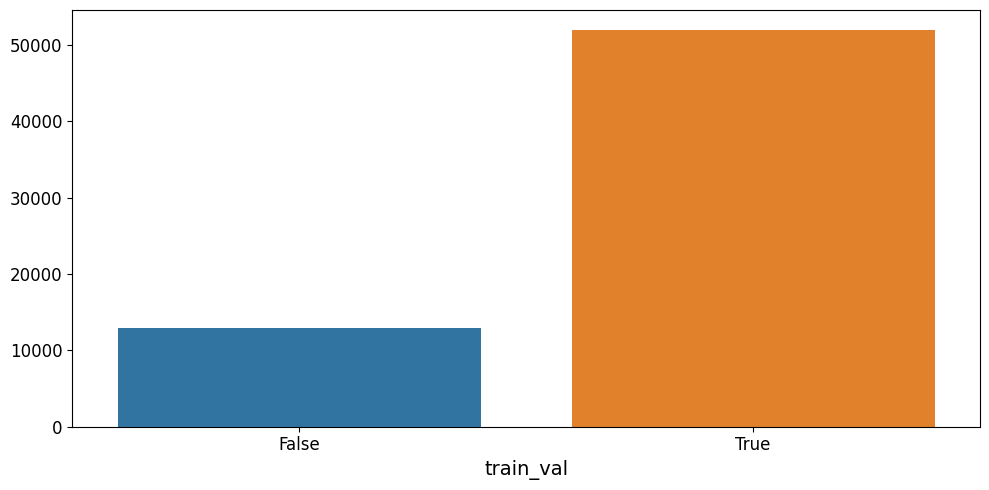

In [16]:
# Check the split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")


In [35]:
sdata_train

<xarray.Dataset>
Dimensions:     (_sequence: 65004, _length: 170, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, _length, length, _ohe
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(846,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(846, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(846,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 1 0 0 0 0 1 ... 0 1 0 1 0 0 0
    id          (_sequence) <U8 'seq07154' 'seq07155' ... 'seq72156' 'seq72157'
    train_val   (_sequence) bool True True False False ... True False True True

In [43]:
### test if you can subset data using other dimensions

#toy=sdata_train.sel(_sequence=(sdata_train["train_val"]==0).compute())  ### example selector using enrichment 
#toy

#toy=sdata_train.sel(_sequence=(sdata_train["enrichment"]>1).compute())  ### example selector using enrichment 


<xarray.Dataset>
Dimensions:     (_sequence: 13001, _length: 170, length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, _length, length, _ohe
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(157,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(157,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(157, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(157,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(157,), meta=np.ndarray>
    ohe_seq     (_sequence, length, _ohe) uint8 0 0 0 1 0 1 0 ... 0 1 0 0 1 0 0
    id          (_sequence) <U8 'seq07158' 'seq07160' ... 'seq72146' 'seq72151'
    train_val   (_sequence) bool False False False False ... False False False

## Training
Now that we have our data ready, it's time to train our model! Training in EUGENe is done through the [PyTorch Lightning (PL) framework](https://www.pytorchlightning.ai/index.html). However PyTorch Lightning does not offer us much help with instantiating model architectures and initializing them. We will utilize EUGENE's library of neural network parts and architectures to do this.

### Instantiation and initialization
We first need to instantiate and initialize our model. We can use the `models` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#models-instantiate-and-initialize-neural-network-architectures) to do this.

In [17]:
from eugene import models

EUGENe offers several options for instantiating a model architecture. Here we will load in a Hybrid architecture that contains convoultional blocks that feed into recurrent layers, finishing with fully connected ones. We have set up a configuration file that trains pretty well on this dataset that you can download from [here](https://github.com/ML4GLand/tutorials/blob/main/configs/hybrid.yaml).

In [16]:
# TODO: Uncomment and run the following to get the hybrid config downloaded
#!mkdir -p $cwd/tutorial_configs
#!wget https://raw.githubusercontent.com/adamklie/EUGENe_paper/revision/configs/jores21/hybrid.yaml -O $cwd/tutorial_configs/hybrid.yaml

We can then use the `load_config` function to load in this configuration file and initialize our model.

In [18]:
model = models.load_config("hybrid.yaml")

We can also print out a summary of the model architecture using the `summary` function. Note that the configuration file we read in here also defines the LightningModule from PL that will be used to train the model. For more details on how this works, check out the [tutorial on instantiating and initializing models](https://github.com/ML4GLand/tutorials/blob/main/eugene/models/instantiating_models.ipynb).

In [19]:
# Print out a summary of the model
model.summary()

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 1.9 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)

In [20]:
# Initialize the weights
models.init_weights(model)

### Model fitting

With a model intantiated and initialized, we are set up to fit our model to our plant promoters! We can do this through the `train` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#train-fit-parameters-to-your-data) in EUGENe

In [21]:
from eugene import train

If you are using GPU accelerators on your machine, you can can use the `gpus` argument to set the number gpus you want to use. If left empty, EUGENe will try to infer the number of GPUs available. Training the model with a single GPU will take less than 5 minutes. Check out the API and docstring for the function below for more details on the arguments you can pass in.

In [64]:
#help(train.fit_sequence_module)

torch.cuda.is_available() ## doesnt work

NameError: name 'torch' is not defined

In [22]:
train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=4,
    prefetch_factor=2,
    drop_last=False,
    name="hybrid",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus="auto"
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory
No seed set


/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /work/project/becbec_005/DeepLearning/EUGENe/tutorial_logs/hybrid/tutorial_model/checkpoints exists and is not empty.

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 1.9 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

We can see how our models trained over time by plotting a training summary. All you need to do is point the [training_summary](https://eugene-tools.readthedocs.io/en/latest/api/eugene.plot.training_summary.html#eugene.plot.training_summary) function to your the EUGENe logging directory.

/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)


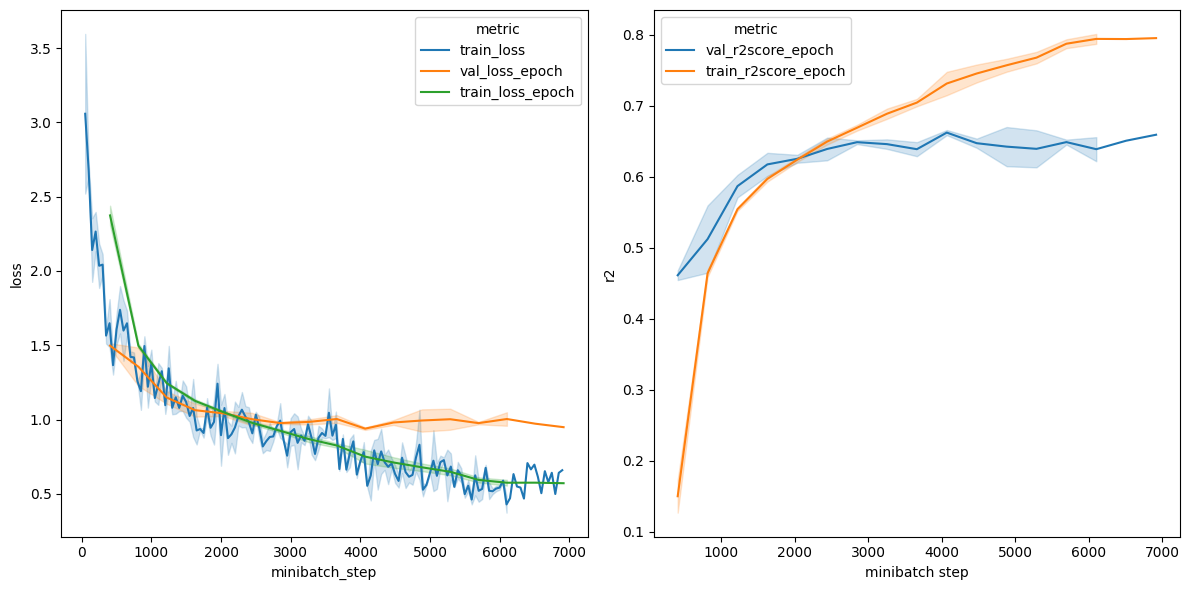

In [23]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "hybrid", "tutorial_model"), metric="r2")

## Evaluation
After the model's been trained, we can evaluate our performance on our held-out test data. This is done through the `evaluate` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#evaluate-validate-and-explore-models-on-new-data).

In [24]:
from eugene import evaluate

We want to use our best model for evaluation. We can see from the training curve above that our model began overfitting the data after about 3000 training steps. Lucky for us, PyTorch Lightning keeps track of our best model for us! We can load this model in from the log directory like so

In [25]:
# We will use the glob Python library to help us find the path to our model
import glob

In [26]:
# We point to the checkpoints directory within the logging directory to grab the best model
model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "tutorial_model", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch)

/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [27]:
best_model.summary()   ### see summary of best model

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.001
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 2}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 1.9 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.703     Total estimated model params size (MB)

Our model is loaded in. Now let's make some predictions

In [28]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name="hybrid",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus="auto"
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Loading ohe_seq and ['enrichment'] into memory


/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

In [29]:
sdata_test

<xarray.Dataset>
Dimensions:                                (_sequence: 7154, _length: 170,
                                            length: 170, _ohe: 4)
Dimensions without coordinates: _sequence, _length, length, _ohe
Data variables:
    enrichment                             (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene                                   (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq                                    (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set                                    (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp                                     (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    ohe_seq                                (_sequence, length, _ohe) uint8 0 ...
    id                                     (_sequence) <U8 'seq00000' ... 'se...
    target                                 (_sequence) float64 -0.5375 ... -1...
    tutorial_model_enrichment_predictions  (_sequence) float32 0.04914 ... -1...

By default, these predictions are automatically stored in the SeqData object:

We know have predictions from our trained model! Let's look at a scatterplot to see how we did

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At 0.4749704490094028 0.7312796976665883 0.689280761667556
Sb 0.6353074460402028 0.9901468129520742 0.8182089377305004
Zm 0.7134482512788243 0.8725061246843718 0.846289760339188


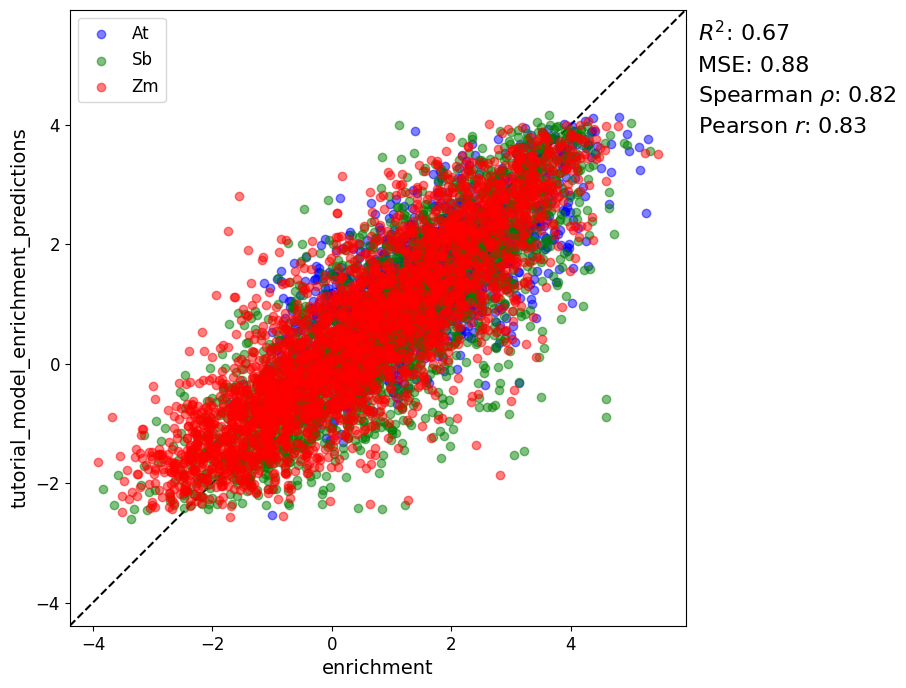

In [30]:
pl.performance_scatter(
    sdata_test, 
    target_vars="enrichment", 
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

Not too shabby. We were able to train a pretty predictive model on this dataset with just DNA sequences as input!

## Interpretation
Seeing good model performance is a big step in the right direction, but is far from the whole picture. We also want to try to better understand what our model is learning. We can do this through model interpretation. Model interpretation in EUGENe is done through the `interpret` [module](https://eugene-tools.readthedocs.io/en/latest/usage-principles.html#seqexplainer-investigate-learned-model-behavior) which relies heavily on functionality built into the `SeqExplainer` [subpackage](https://github.com/ML4GLand/SeqExplainer).

In [31]:
from eugene import interpret

### Filter interpretation
We will first get an idea of what each filter of first convoulional layer of the model is seeing by using the `interpret` module's [`generate_pfms_sdata`](https://eugene-tools.readthedocs.io/en/latest/api/eugene.interpret.generate_pfms_sdata.html?highlight=generate_pfms#eugene.interpret.generate_pfms_sdata) function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.

In [32]:
interpret.generate_pfms_sdata(
    best_model,
    sdata_test,
    seq_var="ohe_seq",
    layer_name="arch.conv1d_tower.layers.1",
    kernel_size=13,
    num_filters=256,
    num_seqlets=100,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Getting activations on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

Now let's visualize a few of these PFMs to see if we can decipher what the filters are picking up on

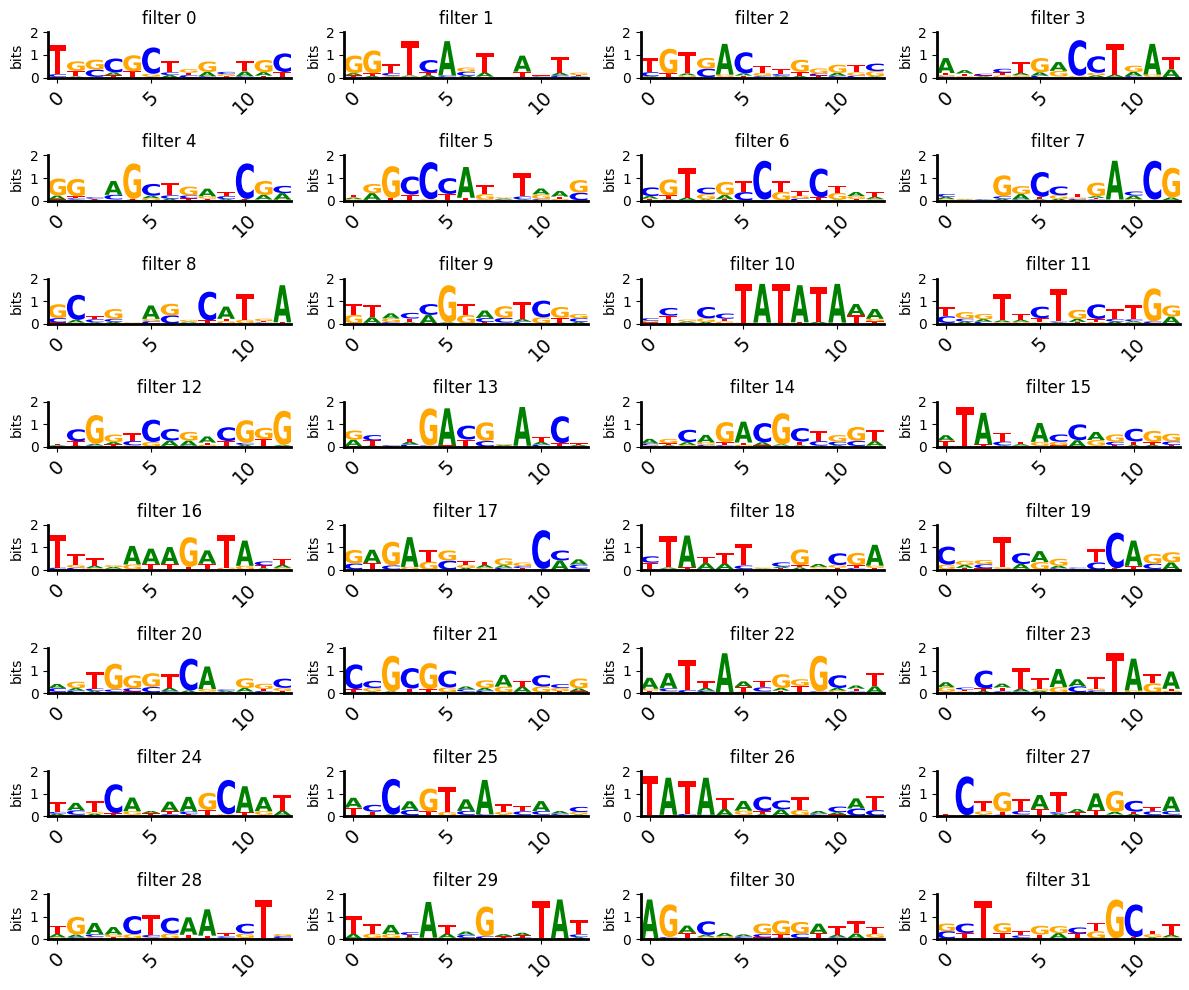

In [33]:
# We can visualize these PFMs as PWM logos
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0, 32),
    pfms_var="arch.conv1d_tower.layers.1_pfms",
    num_rows=8,
    num_cols=4,
    titles=[f"filter {i}" for i in range(0, 32)],
)

The qualitative visualization is nice, but often times we want to put some numbers behind what we are seeing. This is often done by annotating them PFMs from these filters against a database of known motifs with tools like [TomTom](https://meme-suite.org/meme/tools/tomtom). We offer a function for saving filters in an SeqData object to the MEME file format that can uploaded to the TomTom webtool.

In [34]:
interpret.filters_to_meme_sdata(
    sdata_test,
    filters_var="arch.conv1d_tower.layers.1_pfms",
    axis_order=("_arch.conv1d_tower.layers.1_256_filters", "_ohe", "_arch.conv1d_tower.layers.1_13_kernel_size"),
    output_dir=os.path.join(settings.output_dir),
    filename="tutorial_model_best_model_filters.meme"
)

Output directory already exists: /work/project/becbec_005/DeepLearning/EUGENe/tutorial_output
Saved pfm in MEME format as: /work/project/becbec_005/DeepLearning/EUGENe/tutorial_output/tutorial_model_best_model_filters.meme


> **Note**:
> Filters are not always interpretable to a human eye, or for that matter, to TomTom and databases of known motifs. The methods in this analysis are far from perfect, but can be a useful starting point for understanding what your model is learning. For more details on filter interpretation, check out the [filter interpretation tutorial]().

### Attribution analysis
We will next perform an analysis in which we quantify the contribution of each nucleotide of an input sequence to the model's predictions for that sequence. This is called attribution analysis and can be performed in EUGENe with the `attribute_sdata` function. Here we will apply the [DeepLIFT](https://github.com/kundajelab/deeplift) method to our best model on our held-out test sequences.

In [35]:
interpret.attribute_sdata(
    best_model,
    sdata_test,
    method="DeepLift",
    batch_size=128,
    reference_type="zero",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

Computing saliency on batches of size 128:   0%|          | 0/56 [00:00<?, ?it/s]

/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/seqexplainer/attributions/_attributions.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)
/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/jmuhunden/miniconda3/envs/eugene/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:467: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the mo

We can then visualize these importance scores using a sequence logo plot. Here we show the results on the sequences with the highest predicted activity by our model.

In [37]:
help(pl.multiseq_track)

Help on function multiseq_track in module eugene.plot._seq:

multiseq_track(sdata: xarray.core.dataset.Dataset, seq_ids: list, attrs_vars: Union[str, Sequence[str]], id_var='id', ylabs: Optional[list] = None, width: Optional[int] = None, height: Optional[int] = None, return_axes: bool = False, save: Optional[str] = None, **kwargs)
    Plot the saliency tracks for multiple sequences across multiple importance scores in one plot.
    
    Wraps the seq_track function to plot multiple sequences at once across multiple importance scores.
    
    Attempts to make each sequence width proportional to its length and multiply by the number of sequences
    if no width is passed in.
    
    Attempts to make each sequence height proportional to the number of attr_vars passed in (the number of different
    importance scores to plot) if no height is passed in.
    
    Parameters
    ----------
    sdata : xr.Dataset
        The SeqData object with sequences and importances to plot a logo for
  

Importance values:   0%|          | 0/1 [00:00<?, ?it/s]

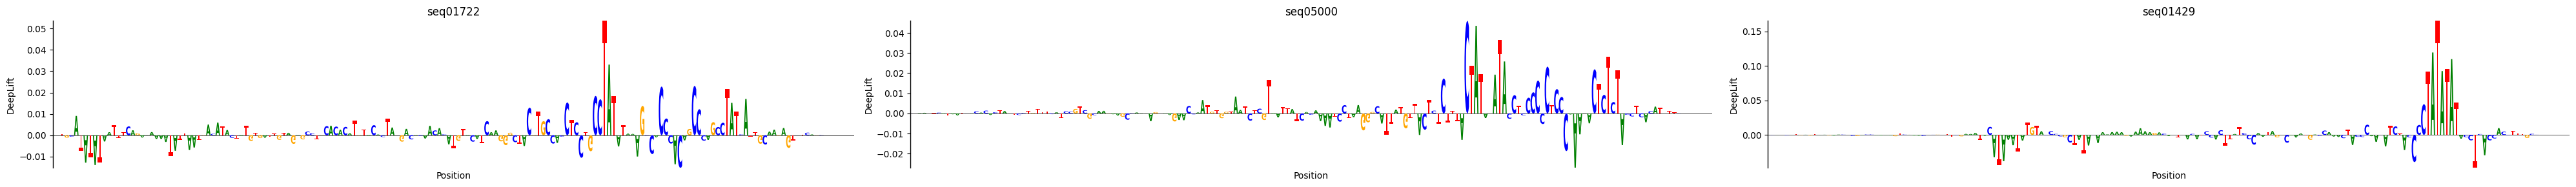

In [36]:
# Grab the top3 in terms of predictions to plot tracks for
top3 = sdata_test["tutorial_model_enrichment_predictions"].to_series().sort_values(ascending=False).iloc[:3].index
ids = sdata_test["id"].values[top3]
pl.multiseq_track(
    sdata_test,
    seq_ids=ids,
    attrs_vars = "DeepLift_attrs",
    ylabs="DeepLift",
    height=3,
    width=40,
)

> **Note**:
> There are many nuances to attribution analysis that we won't get into here. For more details on how this works, check out the [tutorial on attribution analysis](https://github.com/ML4GLand/tutorials/blob/main/seqexplainer/attribution_analysis.ipynb).

### Global importance analysis (GIA)
Another class of interpretation methods that are gaining a lot of traction in the field are those that involve designing experiments for the model *in silico*. The general idea is see what model predicts when we feed it sequences we design ourselves and compare that to some baseline set of predictions. There are no shortage of potential ideas of what sequence to feed the model, but test the positional importance of a TATA box motif. 

We first need some background sequences to establish baseline predictions. Here we use the SeqPro subpackage to generate 5 random sequences and make our own SeqData object from scratch

In [38]:
# Import the packages
import seqpro as sp
import xarray as xr

In [39]:
# Create an SeqData object so its compatible with the function
random_ohe_seq = sp.ohe(sp.random_seqs((5, 170), sp.alphabets.DNA), sp.alphabets.DNA).swapaxes(1, 2)
sdata_random = xr.Dataset({"ohe_seq": (("_sequence", "_ohe", "length"), random_ohe_seq)})
pp.make_unique_ids_sdata(sdata_random, id_var="name")

In [40]:
# Let's get our background predictions
sdata_random["background_predictions"] = best_model.predict(sdata_random["ohe_seq"].values).squeeze()

Predicting on batches: 0it [00:00, ?it/s]

To handle the motif, we will use the MotifData subpackage in EUGENe.

In [41]:
import motifdata as md

In [72]:
# TODO: The motif can be downlaoded from https://github.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/blob/main/data/misc
# !wget https://raw.githubusercontent.com/tobjores/Synthetic-Promoter-Designs-Enabled-by-a-Comprehensive-Analysis-of-Plant-Core-Promoters/main/data/misc/CPEs.meme -O $cwd/tutorial_dataset/CPEs.meme

In [42]:
# We can load it and pull out the PFM and other info about the motif
meme = md.read_meme(os.path.join(settings.dataset_dir, "CPEs.meme"))
motif = meme.motifs["TATA"]
feat_name = motif.name
pfm = motif.pfm
consensus = motif.consensus
consensus_ohe = sp.ohe(consensus, alphabet=sp.alphabets.DNA)
feat_name, pfm, consensus

('TATA',
 array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]),
 'CCCCTATAAATACCCC')

In [54]:
print(feat_name)

TATA


Now that we have a feature, we can implant it at every possible position of the input sequence and see what that does to model predictions.

In [45]:
# This is the EUGENe function that does exactly that!
interpret.positional_gia_sdata(
    model=best_model, 
    sdata=sdata_random, 
    feature=consensus_ohe,
    id_var="name",
    store_var=f"slide_{feat_name}",
    encoding="onehot"
)

Implanting feature in all seqs of sdata:   0%|          | 0/5 [00:00<?, ?it/s]

Next we can visualize the results as a line plot using a custom function from the `plot` module.

In [67]:
#sdata_random
#help(pl.positional_gia_plot)
#sdata_random["slide_TATA"].values
import inspect
print(inspect.getsource(pl.positional_gia_plot)) ### see function call -> Looks like there was a discrepancy in kwarg keys vs var

def positional_gia_plot(
    sdata,
    keys: list,
    id_var: str = "id",
    xlab: str = "Position",
    ylab: str = "Predicted Score",
    ylim: Optional[tuple] = None,
    save: Optional[PathLike] = None,
    return_axes: bool = False,
):
    """Plot a lineplot for each position of the sequence after implanting a feature.

    Assumes that the value corresponding to each seqsm_var in the sdata.uns dictionary
    has the same shape, namely (L, ) where L are the positions where a feature was implanted
    and scores were calculated using a model. Plots the scores as a line plot with a 95% CI
    corresponding to the number of sequences used to make the plot.

    Parameters
    ----------
    sdata : SeqData
        The SeqData object with sequences and scores to plot
    id_var : str
        The name of the variable in sdata.obs to use as the x-axis
    xlab : str
        The x-axis label
    ylab : str
        The y-axis label
    save : PathLike
        The path to save the figur

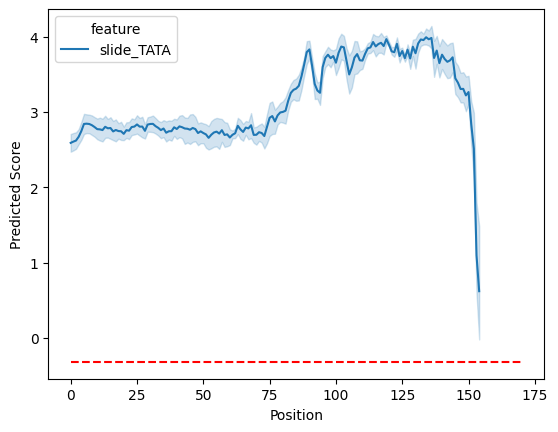

In [68]:
ax = pl.positional_gia_plot(sdata_random, keys=[f"slide_{feat_name}"], id_var="name", return_axes=True)
ax.hlines(sdata_random["background_predictions"].mean(), 0, 170, linestyle="--", color="red")

### Sequence generation
The last class of interpretability methods currently offered in EUGENe uses trained models to guide sequence evolution. We implement the simplest form of this approach that iteratively evolves a sequence by greedily inserting the mutation with the largest predicted impact at each iteration. Starting with an initial sequence (e.g. random, shuffled, etc.), this strategy can be used to evolve synthetic functional sequences.. This style of analysis is a promising direction for further research, and can also serve as an extension of ISM for validating that the model has learned representations that resemble motifs.

In [69]:
# Evolve this sequence for ten rounds
interpret.evolve_seqs_sdata(model=best_model, sdata=sdata_random, rounds=10)

Evolving seqs:   0%|          | 0/5 [00:00<?, ?it/s]

In [70]:
# Get all the vars that start with "evolved"
evolved_vars = ["original_score"] + [var for var in sdata_random.data_vars if var.startswith("evolved") and var.endswith("score")]

In [71]:
# Check the predicted value at each round of evolution
sdata_random[evolved_vars].to_dataframe()

,original_score,evolved_1_score,evolved_2_score,evolved_3_score,evolved_4_score,evolved_5_score,evolved_6_score,evolved_7_score,evolved_8_score,evolved_9_score,evolved_10_score
_sequence,,,,,,,,,,,
0,-0.685769,1.245403,2.689991,2.989048,3.125915,3.250642,3.348908,3.464817,3.545545,3.631798,3.714468
1,0.477861,2.761189,3.033594,3.224647,3.385022,3.544404,3.644397,3.727973,3.795421,3.850521,3.899596
2,-1.021509,0.374563,1.337338,3.052916,3.661712,3.876008,3.969910,4.075282,4.155829,4.212393,4.257110
3,0.095514,2.282891,3.563250,3.846657,3.953109,4.043424,4.106690,4.162224,4.206538,4.249750,4.284883
4,-0.467558,2.107711,2.769192,3.104318,3.321708,3.454101,3.552666,3.629219,3.686426,3.737058,3.783696


## Wrapping up
That concludes our basic usage tutorial! We hope you found it helpful. Don't hesitate to raise a GitHub issue if you run into any errors or if anything is overly confusing!

You can find tutorials dedicated to many of the specific steps shown here on the tutorials repo (https://github.com/ML4GLand/tutorials)

---